# pip install requirements

In [1]:
!pip install pytorch-lightning
!pip install statsmodels
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [2]:
!which python

/usr/local/bin/python


In [3]:
!python --version

Python 3.10.12


In [4]:
import statsmodels
import os, sys
from argparse import Namespace
import numpy as np
import pandas as pd
from pathlib import Path
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
#import wandb

plt.style.use('tableau-colorblind10')

In [5]:
print('Python version:', sys.version)
print('Package versions:')
print('Pytorch:', torch.__version__)
print('Pytorch-Lightning:', pl.__version__)
print('Matplotlib:', matplotlib.__version__)
print('scikit-learn:', sklearn.__version__)
#print('Weights&Biases:', wandb.__version__)

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Package versions:
Pytorch: 2.2.1+cu121
Pytorch-Lightning: 2.2.4
Matplotlib: 3.7.1
scikit-learn: 1.2.2


# Загрузка датасета

In [143]:
datafile_path = Path('/content/1st nightframe.csv')
datasets_root = Path('/content')

In [144]:
raw_dt = pd.read_csv(datafile_path)
raw_dt.head(20)

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,103.12.198.162,39.62.1.38,UDP,1274,443 > 45841 Len=1232
1,2,-0.005975,39.62.1.38,142.250.181.54,TCP,78,2655 > 443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...
2,3,-0.005898,39.62.1.38,103.12.198.146,TCP,66,44538 > 443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...
3,4,-0.005898,39.62.1.38,103.12.198.146,TCP,66,44540 > 443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...
4,5,-0.005889,39.62.1.38,103.12.198.146,TCP,66,44540 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...
5,6,-0.005888,39.62.1.38,103.12.198.146,TCP,66,44538 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...
6,7,-0.005881,39.62.1.38,103.12.198.146,TCP,66,44538 > 443 [ACK] Seq=1 Ack=6901 Win=1736 Le...
7,8,-0.005881,39.62.1.38,103.12.198.146,TCP,66,44540 > 443 [ACK] Seq=1 Ack=6901 Win=1736 Le...
8,9,-0.005875,39.62.1.38,103.12.198.146,TCP,66,44540 > 443 [ACK] Seq=1 Ack=13801 Win=1730 L...
9,10,-0.005870,39.62.1.38,103.12.198.146,TCP,66,44540 > 443 [ACK] Seq=1 Ack=16561 Win=1730 L...


In [145]:
raw_dt.describe()

,No.,Time,Length
count,94279.000000,94279.000000,94279.000000
mean,47140.000000,25.098489,886.476554
std,27216.147352,14.197638,804.809599
min,1.000000,-0.005975,43.000000
25%,23570.500000,12.722099,77.000000
50%,47140.000000,25.219146,1274.000000
75%,70709.500000,37.823251,1446.000000
max,94279.000000,49.979508,8466.000000


In [197]:
data = raw_dt

In [198]:
data.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info,Stable,Processing_time
0,1,0.000000,103.12.198.162,39.62.1.38,UDP,1274,443 > 45841 Len=1232,0,1
1,2,-0.005975,39.62.1.38,142.250.181.54,TCP,78,2655 > 443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...,0,1
2,3,-0.005898,39.62.1.38,103.12.198.146,TCP,66,44538 > 443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...,0,2
3,4,-0.005898,39.62.1.38,103.12.198.146,TCP,66,44540 > 443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...,0,2
4,5,-0.005889,39.62.1.38,103.12.198.146,TCP,66,44540 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...,0,1
5,6,-0.005888,39.62.1.38,103.12.198.146,TCP,66,44538 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...,0,3
6,7,-0.005881,39.62.1.38,103.12.198.146,TCP,66,44538 > 443 [ACK] Seq=1 Ack=6901 Win=1736 Le...,0,1
7,8,-0.005881,39.62.1.38,103.12.198.146,TCP,66,44540 > 443 [ACK] Seq=1 Ack=6901 Win=1736 Le...,0,3
8,9,-0.005875,39.62.1.38,103.12.198.146,TCP,66,44540 > 443 [ACK] Seq=1 Ack=13801 Win=1730 L...,0,3
9,10,-0.005870,39.62.1.38,103.12.198.146,TCP,66,44540 > 443 [ACK] Seq=1 Ack=16561 Win=1730 L...,0,3


осреднение передачи первого ключевого кадра для тренировочной выборки

In [199]:
data['Stable'] = "True"
data['Processing_time'] = np.random.randint(1, 4, size=len(data))
data['Source'] = data['Source'].str.replace('.', '')
data['Destination'] = data['Destination'].str.replace('.', '')
#df['Time'] = pd.to_datetime(df['Time'], unit='s')

Определяем характеристики датасета

In [200]:
cont_vars = ['Length','Processing_time']
cat_vars = ['Stable','Protocol']

In [201]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars]
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])

data

,No.,Time,Source,Destination,Protocol,Length,Info,Stable,Processing_time
0,1,0.000000,10312198162,3962138,26,1274,443 > 45841 Len=1232,0,2
1,2,-0.005975,3962138,14225018154,20,78,2655 > 443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...,0,1
2,3,-0.005898,3962138,10312198146,20,66,44538 > 443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...,0,1
3,4,-0.005898,3962138,10312198146,20,66,44540 > 443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...,0,1
4,5,-0.005889,3962138,10312198146,20,66,44540 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...,0,1
...,...,...,...,...,...,...,...,...,...
94274,94275,49.978907,1037310383,3962138,16,2866,"[TCP Previous segment not captured] , Continua...",0,2
94275,94276,49.979060,3962138,10373103205,26,84,27503 > 443 Len=42,0,2
94276,94277,49.979283,3962138,10312198162,26,76,45841 > 443 Len=34,0,1
94277,94278,49.979383,10373100207,3962138,26,1292,443 > 54811 Len=1250,0,2


In [202]:
data.drop(columns=['No.','Info'])

,Time,Source,Destination,Protocol,Length,Stable,Processing_time
0,0.000000,10312198162,3962138,26,1274,0,2
1,-0.005975,3962138,14225018154,20,78,0,1
2,-0.005898,3962138,10312198146,20,66,0,1
3,-0.005898,3962138,10312198146,20,66,0,1
4,-0.005889,3962138,10312198146,20,66,0,1
...,...,...,...,...,...,...,...
94274,49.978907,1037310383,3962138,16,2866,0,2
94275,49.979060,3962138,10373103205,26,84,0,2
94276,49.979283,3962138,10312198162,26,76,0,1
94277,49.979383,10373100207,3962138,26,1292,0,2


In [203]:
data.to_csv('/content/dataprepared.csv', index=False)

In [204]:
test_ratio = 0.1

In [205]:
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [206]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [207]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [208]:
tr_data, tr_data_scaled

(         No.       Time       Source  Destination  Protocol  Length  \
 0          1   0.000000  10312198162      3962138        26    1274   
 1          2  -0.005975      3962138  14225018154        20      78   
 2          3  -0.005898      3962138  10312198146        20      66   
 3          4  -0.005898      3962138  10312198146        20      66   
 4          5  -0.005889      3962138  10312198146        20      66   
 ...      ...        ...          ...          ...       ...     ...   
 84846  84847  44.029613      3962138  10312198162        26      77   
 84847  84848  44.029661  10373100140      3962138        26    1292   
 84848  84849  44.029711    103891347      3962138        26     350   
 84849  84850  44.029711  10373100206      3962138        26    1392   
 84850  84851  44.029735      3962138  10373103205        20      66   
 
                                                     Info  Stable  \
 0                                 443  >  45841 Len=1232       0

In [209]:
tr_data_scaled.to_csv('train.csv', index=False)
tst_data_scaled.to_csv('test.csv', index=False)

# АРХИТЕКТУРА ВАЕ

In [261]:
class TSDataset(Dataset):
    def __init__(self, split, cont_vars=None, cat_vars=None, lbl_as_feat=True):
        """
        split: 'train' if we want to get data from the training examples, 'test' for
        test examples, or 'both' to merge the training and test sets and return samples
        from either.
        cont_vars: List of continuous variables to return as features. If None, returns
        all continuous variables available.
        cat_vars: Same as above, but for categorical variables.
        lbl_as_feat: Set to True when training a VAE -- the labels (temperature values)
        will be included as another dimension of the data. Set to False when training
        a model to predict temperatures.
        """
        super().__init__()
        assert split in ['train', 'test', 'both']
        self.lbl_as_feat = lbl_as_feat
        if split == 'train':
            self.df = pd.read_csv(datasets_root/'train.csv')
        elif split == 'test':
            self.df = pd.read_csv(datasets_root/'test.csv')
        else:
            df1 = pd.read_csv(datasets_root/'train.csv')
            df2 = pd.read_csv(datasets_root/'test.csv')
            self.df = pd.concat((df1, df2), ignore_index=True)

        # Select continuous variables to use
        if cont_vars:
            self.cont_vars = cont_vars
            # If we want to use 'value' as a feature, ensure it is returned
            if self.lbl_as_feat:
                try:
                    assert 'Length' in self.cont_vars
                except AssertionError:
                    self.cont_vars.insert(0, 'Length')
            # If not, ensure it not returned as a feature
            else:
                try:
                    assert 'Length' not in self.cont_vars
                except AssertionError:
                    self.cont_vars.remove('Length','Protocol','Processing_time','Source','Destination')

        else:  # if no list provided, use all available
            self.cont_vars = ['Length']

        # Select categorical variables to use
        if cat_vars:
            self.cat_vars = cat_vars
        else:  # if no list provided, use all available
            self.cat_vars = ['Stable']

        # Finally, make two Numpy arrays for continuous and categorical
        # variables, respectively:
        if self.lbl_as_feat:
            self.cont = self.df[self.cont_vars].copy().to_numpy(dtype=np.float32)
        else:
            self.cont = self.df[self.cont_vars].copy().to_numpy(dtype=np.float32)
            self.lbl = self.df['Length'].copy().to_numpy(dtype=np.float32)
        self.cat = self.df[self.cat_vars].copy().to_numpy(dtype=np.int64)

    def __getitem__(self, idx):
        if self.lbl_as_feat:  # for VAE training
            return torch.tensor(self.cont[idx]), torch.tensor(self.cat[idx])
        else:  # for supervised prediction
            return torch.tensor(self.cont[idx]), torch.tensor(self.cat[idx]), torch.tensor(self.lbl[idx])

    def __len__(self):
        return self.df.shape[0]

In [262]:
ds = TSDataset(split='both', cont_vars=['Length',], cat_vars=['Stable'], lbl_as_feat=True)
print(len(ds))
it = iter(ds)
for _ in range(10):
    print(next(it))

94279
(tensor([0.4876]), tensor([0]))
(tensor([-1.0110]), tensor([0]))
(tensor([-1.0261]), tensor([0]))
(tensor([-1.0261]), tensor([0]))
(tensor([-1.0261]), tensor([0]))
(tensor([-1.0261]), tensor([0]))
(tensor([-1.0261]), tensor([0]))
(tensor([-1.0261]), tensor([0]))
(tensor([-1.0261]), tensor([0]))
(tensor([-1.0261]), tensor([0]))


In [263]:
data.dtypes

No.                  int64
Time               float64
Source              object
Destination         object
Protocol             int64
Length               int64
Info                object
Stable               int64
Processing_time      int64
dtype: object

In [264]:
class Layer(nn.Module):
    '''
    A single fully connected layer with optional batch normalisation and activation.
    '''
    def __init__(self, in_dim, out_dim, bn = True):
        super().__init__()
        layers = [nn.Linear(in_dim, out_dim)]
        if bn: layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.LeakyReLU(0.1, inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class Encoder(nn.Module):
    '''
    The encoder part of our VAE. Takes a data sample and returns the mean and the log-variance of the
    latent vector's distribution.
    '''
    def __init__(self, **hparams):
        super().__init__()
        self.hparams = Namespace(**hparams)
        self.embeds = nn.ModuleList([
            nn.Embedding(n_cats, emb_size) for (n_cats, emb_size) in self.hparams.embedding_sizes
        ])
        # The input to the first layer is the concatenation of all embedding vectors and continuous
        # values
        in_dim = sum(emb.embedding_dim for emb in self.embeds) + len(self.hparams.cont_vars)
        layer_dims = [in_dim] + [int(s) for s in self.hparams.layer_sizes.split(',')]
        bn = self.hparams.batch_norm
        self.layers = nn.Sequential(
            *[Layer(layer_dims[i], layer_dims[i + 1], bn) for i in range(len(layer_dims) - 1)],
        )
        self.mu = nn.Linear(layer_dims[-1], self.hparams.latent_dim)
        self.logvar = nn.Linear(layer_dims[-1], self.hparams.latent_dim)

    def forward(self, x_cont, x_cat):
        x_embed = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]
        x_embed = torch.cat(x_embed, dim=1)
        x = torch.cat((x_embed, x_cont), dim=1)
        h = self.layers(x)
        mu_ = self.mu(h)
        logvar_ = self.logvar(h)
        return mu_, logvar_, x  # we return the concatenated input vector for use in loss fn


class Decoder(nn.Module):
    '''
    The decoder part of our VAE. Takes a latent vector (sampled from the distribution learned by the
    encoder) and converts it back to a reconstructed data sample.
    '''
    def __init__(self, **hparams):
        super().__init__()
        self.hparams = Namespace(**hparams)
        hidden_dims = [self.hparams.latent_dim] + [int(s) for s in reversed(self.hparams.layer_sizes.split(','))]
        out_dim = sum(emb_size for _, emb_size in self.hparams.embedding_sizes) + len(self.hparams.cont_vars)
        bn = self.hparams.batch_norm
        self.layers = nn.Sequential(
            *[Layer(hidden_dims[i], hidden_dims[i + 1], bn) for i in range(len(hidden_dims) - 1)],
        )
        self.reconstructed = nn.Linear(hidden_dims[-1], out_dim)

    def forward(self, z):
        h = self.layers(z)
        recon = self.reconstructed(h)
        return recon

In [265]:
class VAE(pl.LightningModule):
    def __init__(self, **hparams):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(**hparams)
        self.decoder = Decoder(**hparams)

    def reparameterize(self, mu, logvar):
        '''
        The reparameterisation trick allows us to backpropagate through the encoder.
        '''
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std) * self.hparams.stdev
            return eps * std + mu
        else:
            return mu

    def forward(self, batch):
        x_cont, x_cat = batch
        assert x_cat.dtype == torch.int64
        mu, logvar, x = self.encoder(x_cont, x_cat)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar, x

    def loss_function(self, obs, recon, mu, logvar):
        recon_loss = F.smooth_l1_loss(recon, obs, reduction='mean')
        kld = -0.5 * torch.mean(1 + logvar - mu ** 2 - logvar.exp())
        return recon_loss, kld

    def training_step(self, batch, batch_idx):
        recon, mu, logvar, x = self.forward(batch)
        # The loss function compares the concatenated input vector including
        # embeddings to the reconstructed vector
        recon_loss, kld = self.loss_function(x, recon, mu, logvar)
        loss = recon_loss + self.hparams.kld_beta * kld

        self.log('total_loss', loss.mean(dim=0), on_step=True, prog_bar=True,
                 logger=True)
        self.log('recon_loss', recon_loss.mean(dim=0), on_step=True, prog_bar=True,
                 logger=True)
        self.log('kld', kld.mean(dim=0), on_step=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        recon, mu, logvar, x = self.forward(batch)
        recon_loss, kld = self.loss_function(x, recon, mu, logvar)
        loss = recon_loss + self.hparams.kld_beta * kld
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay,
                                eps=1e-4)
        sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            opt, T_0=25, T_mult=1, eta_min=1e-9, last_epoch=-1)
        return [opt], [sch]

    def train_dataloader(self):
        dataset = TSDataset('train', cont_vars=self.hparams.cont_vars,
            cat_vars = self.hparams.cat_vars, lbl_as_feat=True
        )
        return DataLoader(dataset, batch_size=self.hparams.batch_size, num_workers=2,
            pin_memory=True, persistent_workers=True, shuffle=True
        )

    def test_dataloader(self):
        dataset = TSDataset('test', cont_vars=self.hparams.cont_vars,
            cat_vars=self.hparams.cat_vars, lbl_as_feat=True
        )
        return DataLoader(dataset, batch_size=self.hparams.batch_size, num_workers=2,
            pin_memory=True, persistent_workers=True
        )

# готовим данные

In [267]:
cont_features = ['Length']
cat_features = ['Stable']

embed_cats = [len(tr_data_scaled[c].unique()) for c in cat_features]

hparams = OrderedDict(
    run='embsz16_latsz16_bsz128_lay64-128-256-128-64_ep100_cosineWR_v1',
    cont_vars = cont_features,
    cat_vars = cat_features,
    embedding_sizes = [(embed_cats[i], 16) for i in range(len(embed_cats))],
    latent_dim = 16,
    layer_sizes = '64,128,256,128,64',
    batch_norm = True,
    stdev = 0.1,
    kld_beta = 0.05,
    lr = 0.001,
    weight_decay = 1e-5,
    batch_size = 128,
    epochs = 1,
)

In [268]:
hparams

OrderedDict([('run',
              'embsz16_latsz16_bsz128_lay64-128-256-128-64_ep100_cosineWR_v1'),
             ('cont_vars', ['Length']),
             ('cat_vars', ['Stable']),
             ('embedding_sizes', [(1, 16)]),
             ('latent_dim', 16),
             ('layer_sizes', '64,128,256,128,64'),
             ('batch_norm', True),
             ('stdev', 0.1),
             ('kld_beta', 0.05),
             ('lr', 0.001),
             ('weight_decay', 1e-05),
             ('batch_size', 128),
             ('epochs', 1)])

# обучаем модель ВАЕ

In [269]:
model = VAE(**hparams)
#logger = WandbLogger(name=hparams['run'], project='VAE_Anomaly', version=hparams['run'],
#     save_dir='contest'
#)
ckpt_callback = pl.callbacks.ModelCheckpoint(dirpath='.', filename='vae_weights')
# Replace argument logger by None if you don't have a WandB account (and don't want to create one)
trainer = pl.Trainer(accelerator='cpu', devices=1, strategy='auto',
                     max_epochs=hparams['epochs'], benchmark=True,
                     callbacks=[ckpt_callback], gradient_clip_val=10., enable_model_summary=True,
)
# tuning = trainer.tune(model)
# print(f"Initial learning rate set at {tuning['lr_find'].suggestion()}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [270]:
trainer.fit(model)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 87.0 K
1 | decoder | Decoder | 86.0 K
------------------------------------
172 K     Trainable params
0         Non-trainable params
172 K     Total params
0.692     Total estimated model params size (MB)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [271]:
trainer.test(model)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0007735663675703108   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0007735663675703108}]

In [272]:
dataset = TSDataset('train', cont_vars=hparams['cont_vars'],
                    cat_vars=hparams['cat_vars'],
                    lbl_as_feat=True)

In [273]:
device = torch.device('cpu:0')  # или 'cpu', в зависимости от вашей конфигурации
#device = torch.device('cuda:0')  # или 'cpu', в зависимости от вашей конфигурации

In [274]:
trained_model = VAE.load_from_checkpoint('/content/vae_weights.ckpt')
#trained_model.cuda()
trained_model.freeze()

#pred = model(x.cuda())

losses = []
# run predictions for the training set examples
for i in range(len(dataset)):
    x_cont, x_cat = dataset[i]
    x_cont.unsqueeze_(0)
    x_cat.unsqueeze_(0)
#   recon, mu, logvar, x = trained_model.forward((x_cont.cuda(), x_cat.cuda())) #для передачи в cuda
    recon, mu, logvar, x = trained_model.forward((x_cont, x_cat))
    recon_loss, kld = trained_model.loss_function(x, recon, mu, logvar)
    losses.append(recon_loss + trained_model.hparams.kld_beta * kld)

data_with_losses = dataset.df
data_with_losses['loss'] = torch.asarray(losses)
data_with_losses.sort_values('No.', inplace=True)
data_with_losses.head()

,No.,Time,Source,Destination,Protocol,Length,Info,Stable,Processing_time,loss
0,1,0.000000,10312198162,3962138,26,0.487584,443 > 45841 Len=1232,0,-0.001849,0.044191
1,2,-0.005975,3962138,14225018154,20,-1.011020,2655 > 443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...,0,-1.227586,0.053132
2,3,-0.005898,3962138,10312198146,20,-1.026056,44538 > 443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...,0,-1.227586,0.053245
3,4,-0.005898,3962138,10312198146,20,-1.026056,44540 > 443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...,0,-1.227586,0.053245
4,5,-0.005889,3962138,10312198146,20,-1.026056,44540 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...,0,-1.227586,0.053245


In [275]:
data_with_losses.sort_values('No.', inplace=True)
data_with_losses.head(2000)

,No.,Time,Source,Destination,Protocol,Length,Info,Stable,Processing_time,loss
0,1,0.000000,10312198162,3962138,26,0.487584,443 > 45841 Len=1232,0,-0.001849,0.044191
1,2,-0.005975,3962138,14225018154,20,-1.011020,2655 > 443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...,0,-1.227586,0.053132
2,3,-0.005898,3962138,10312198146,20,-1.026056,44538 > 443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...,0,-1.227586,0.053245
3,4,-0.005898,3962138,10312198146,20,-1.026056,44540 > 443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...,0,-1.227586,0.053245
4,5,-0.005889,3962138,10312198146,20,-1.026056,44540 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...,0,-1.227586,0.053245
...,...,...,...,...,...,...,...,...,...,...
1995,1996,1.076976,3962138,10312198162,26,-1.012273,45841 > 443 Len=35,0,1.223888,0.053148
1996,1997,1.077019,10312198163,3962138,16,2.432261,"[TCP Previous segment not captured] , Continua...",0,-1.227586,0.048344
1997,1998,1.077085,3962138,10312198163,20,-1.011020,[TCP Dup ACK 1982#1] 29744 > 443 [ACK] Seq=1...,0,-1.227586,0.053132
1998,1999,1.077114,3962138,21658220206,20,-1.026056,57366 > 443 [ACK] Seq=2 Ack=2 Win=344 Len=0 ...,0,1.223888,0.053245


#смотрим результаты детектора аномалий

In [276]:
mean, sigma = data_with_losses['loss'].mean(), data_with_losses['loss'].std()
mean, sigma

(0.048536863, 0.005053858)

In [277]:
quant = 0.999
thresh = data_with_losses['loss'].quantile(quant)  # threshold for anomaly (quantile).
thresh

0.07803705334663391

In [278]:
data_with_losses['anomaly'] = data_with_losses['loss'] > thresh
print(data_with_losses.head())

   No.      Time       Source  Destination  Protocol    Length  \
0    1  0.000000  10312198162      3962138        26  0.487584   
1    2 -0.005975      3962138  14225018154        20 -1.011020   
2    3 -0.005898      3962138  10312198146        20 -1.026056   
3    4 -0.005898      3962138  10312198146        20 -1.026056   
4    5 -0.005889      3962138  10312198146        20 -1.026056   

                                                Info  Stable  Processing_time  \
0                             443  >  45841 Len=1232       0        -0.001849   
1  2655  >  443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...       0        -1.227586   
2  44538  >  443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...       0        -1.227586   
3  44540  >  443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...       0        -1.227586   
4  44540  >  443 [ACK] Seq=1 Ack=2761 Win=1736 Le...       0        -1.227586   

       loss  anomaly  
0  0.044191    False  
1  0.053132    False  
2  0.053245    False  
3  0.053245    False  
4

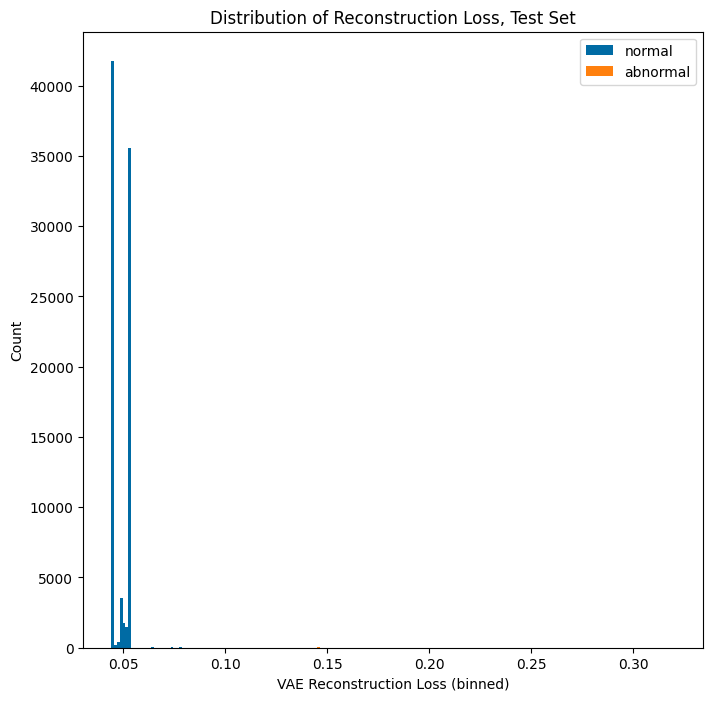

In [279]:
plt.figure(figsize=(8, 8))
anomalies_loss = data_with_losses.loc[data_with_losses['anomaly'], 'loss']
normals_loss   = data_with_losses.loc[~data_with_losses['anomaly'], 'loss']
plt.hist([normals_loss, anomalies_loss], bins=200, stacked=True, label=['normal', 'abnormal'])
plt.title("Distribution of Reconstruction Loss, Test Set")
plt.xlabel("VAE Reconstruction Loss (binned)")
plt.ylabel("Count")
plt.legend();

In [280]:
data_with_losses_unscaled = data_with_losses.copy()
#data_with_losses_unscaled[cont_vars] = scaler.inverse_transform(data_with_losses[cont_vars])
for enc, var in zip(label_encoders, cat_vars):
    data_with_losses_unscaled[var] = enc.inverse_transform(data_with_losses[var])
data_with_losses_unscaled = pd.DataFrame(data_with_losses_unscaled, columns=data_with_losses.columns)
#data_with_losses_unscaled['Шаг'] = pd.to_datetime(data_with_losses_unscaled['Шаг'] * 1e11, unit='ns')

print(data_with_losses_unscaled.head())

   No.      Time       Source  Destination Protocol    Length  \
0    1  0.000000  10312198162      3962138      UDP  0.487584   
1    2 -0.005975      3962138  14225018154      TCP -1.011020   
2    3 -0.005898      3962138  10312198146      TCP -1.026056   
3    4 -0.005898      3962138  10312198146      TCP -1.026056   
4    5 -0.005889      3962138  10312198146      TCP -1.026056   

                                                Info Stable  Processing_time  \
0                             443  >  45841 Len=1232   True        -0.001849   
1  2655  >  443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...   True        -1.227586   
2  44538  >  443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...   True        -1.227586   
3  44540  >  443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...   True        -1.227586   
4  44540  >  443 [ACK] Seq=1 Ack=2761 Win=1736 Le...   True        -1.227586   

       loss  anomaly  
0  0.044191    False  
1  0.053132    False  
2  0.053245    False  
3  0.053245    False  
4  0.053245  

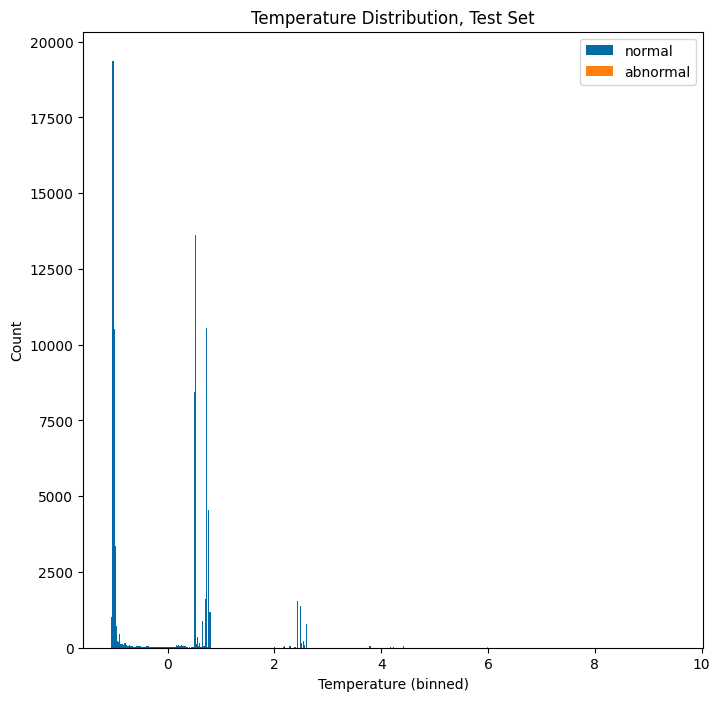

In [281]:
anomalies_value = data_with_losses_unscaled.loc[data_with_losses_unscaled['anomaly'], ['loss','Length']]
normals_value = data_with_losses_unscaled.loc[~data_with_losses_unscaled['anomaly'], ['loss','Length']]
plt.figure(figsize=(8,8))
plt.hist([normals_value['Length'], anomalies_value['Length']], bins=500, stacked=True, label=['normal', 'abnormal'])
plt.title("Temperature Distribution, Test Set")
plt.xlabel("Temperature (binned)")
plt.ylabel("Count")
plt.legend()

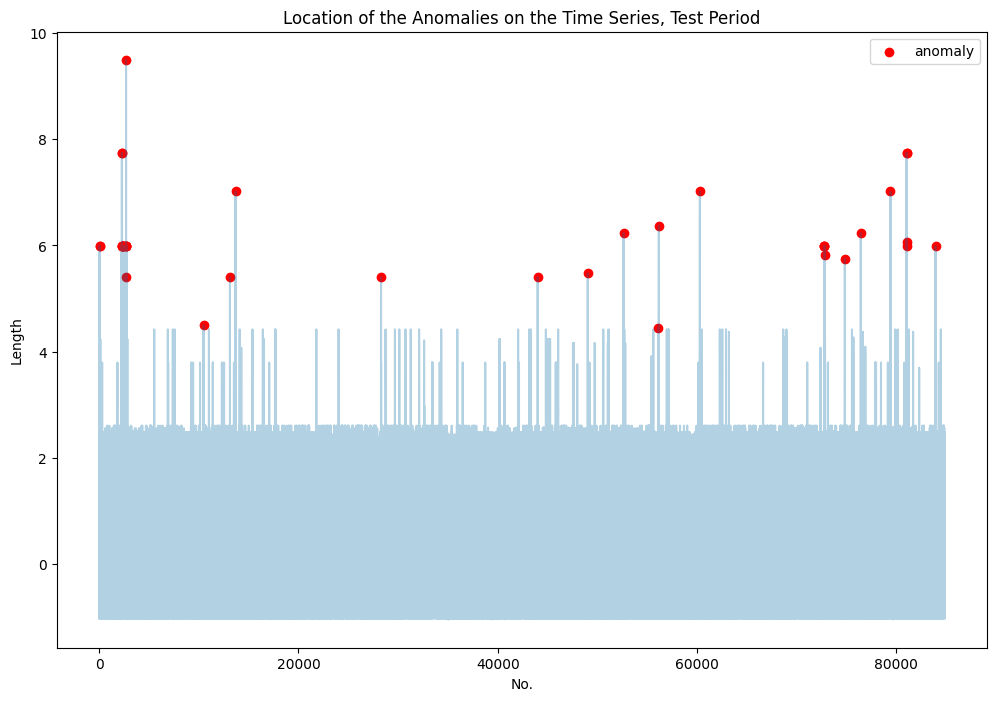

In [282]:
anomalies_ts = data_with_losses_unscaled.loc[data_with_losses_unscaled['anomaly'], ('No.', 'Length')]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data_with_losses_unscaled['No.'], data_with_losses_unscaled['Length'], alpha=0.3)
ax.scatter(anomalies_ts['No.'], anomalies_ts['Length'], color='red', label='anomaly')
plt.legend()
plt.xlabel("No.")
plt.ylabel("Length")
plt.title("Location of the Anomalies on the Time Series, Test Period");

#**Возвращаемся к анализу аномалий на тестовой дате, но уже используем прогнозы по битрейту на обучающих данных. Сгенерируем подозрительный трафик**

In [317]:
data_val=raw_dt
data_val

,No.,Time,Source,Destination,Protocol,Length,Info,Stable,Processing_time
0,1,0.000000,10312198162,3962138,26,0,443 > 45841 Len=1232,0,2
1,2,-0.005975,3962138,14225018154,20,0,2655 > 443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...,0,1
2,3,-0.005898,3962138,10312198146,20,0,44538 > 443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...,0,1
3,4,-0.005898,3962138,10312198146,20,0,44540 > 443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...,0,1
4,5,-0.005889,3962138,10312198146,20,0,44540 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...,0,1
...,...,...,...,...,...,...,...,...,...
94274,94275,49.978907,1037310383,3962138,16,2866,"[TCP Previous segment not captured] , Continua...",0,2
94275,94276,49.979060,3962138,10373103205,26,84,27503 > 443 Len=42,0,2
94276,94277,49.979283,3962138,10312198162,26,76,45841 > 443 Len=34,0,1
94277,94278,49.979383,10373100207,3962138,26,1292,443 > 54811 Len=1250,0,2


In [318]:
data_val.loc[:29, 'Length'] = 3000

In [319]:
test_data=data_val
test_data

,No.,Time,Source,Destination,Protocol,Length,Info,Stable,Processing_time
0,1,0.000000,10312198162,3962138,26,3000,443 > 45841 Len=1232,0,2
1,2,-0.005975,3962138,14225018154,20,3000,2655 > 443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...,0,1
2,3,-0.005898,3962138,10312198146,20,3000,44538 > 443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...,0,1
3,4,-0.005898,3962138,10312198146,20,3000,44540 > 443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...,0,1
4,5,-0.005889,3962138,10312198146,20,3000,44540 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...,0,1
...,...,...,...,...,...,...,...,...,...
94274,94275,49.978907,1037310383,3962138,16,2866,"[TCP Previous segment not captured] , Continua...",0,2
94275,94276,49.979060,3962138,10373103205,26,84,27503 > 443 Len=42,0,2
94276,94277,49.979283,3962138,10312198162,26,76,45841 > 443 Len=34,0,1
94277,94278,49.979383,10373100207,3962138,26,1292,443 > 54811 Len=1250,0,2


In [320]:
cont_vars = ['Length', 'Source', 'Destination', 'Processing_time']
cat_vars = ['Stable','Protocol']

from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars]
for col, enc in zip(cat_vars, label_encoders):
    test_data[col] = enc.fit_transform(test_data[col])

test_data

,No.,Time,Source,Destination,Protocol,Length,Info,Stable,Processing_time
0,1,0.000000,10312198162,3962138,26,3000,443 > 45841 Len=1232,0,2
1,2,-0.005975,3962138,14225018154,20,3000,2655 > 443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...,0,1
2,3,-0.005898,3962138,10312198146,20,3000,44538 > 443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...,0,1
3,4,-0.005898,3962138,10312198146,20,3000,44540 > 443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...,0,1
4,5,-0.005889,3962138,10312198146,20,3000,44540 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...,0,1
...,...,...,...,...,...,...,...,...,...
94274,94275,49.978907,1037310383,3962138,16,2866,"[TCP Previous segment not captured] , Continua...",0,2
94275,94276,49.979060,3962138,10373103205,26,84,27503 > 443 Len=42,0,2
94276,94277,49.979283,3962138,10312198162,26,76,45841 > 443 Len=34,0,1
94277,94278,49.979383,10373100207,3962138,26,1292,443 > 54811 Len=1250,0,2


In [322]:
test_ratio = 0.001

tr_data = test_data.iloc[: int(len(test_data) * (1 - test_ratio))]
tst_data = test_data.iloc[int(len(test_data) * (1 - test_ratio)) :]
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

tr_data_scaled.to_csv('train.csv', index=False)
tst_data_scaled.to_csv('test.csv', index=False)

In [323]:
ds = TSDataset(split='both', cont_vars=['Length',], cat_vars=['Stable'], lbl_as_feat=True)
print(len(ds))
it = iter(ds)
for _ in range(10):
    print(next(it))

94279
(tensor([2.6237]), tensor([0]))
(tensor([2.6237]), tensor([0]))
(tensor([2.6237]), tensor([0]))
(tensor([2.6237]), tensor([0]))
(tensor([2.6237]), tensor([0]))
(tensor([2.6237]), tensor([0]))
(tensor([2.6237]), tensor([0]))
(tensor([2.6237]), tensor([0]))
(tensor([2.6237]), tensor([0]))
(tensor([2.6237]), tensor([0]))


In [324]:
tr_data_scaled

,No.,Time,Source,Destination,Protocol,Length,Info,Stable,Processing_time
0,1,0.000000,0.092042,-0.304479,26,2.623732,443 > 45841 Len=1232,0,-0.001926
1,2,-0.005975,-0.398769,0.462563,20,2.623732,2655 > 443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...,0,-1.227310
2,3,-0.005898,-0.398769,0.251517,20,2.623732,44538 > 443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...,0,-1.227310
3,4,-0.005898,-0.398769,0.251517,20,2.623732,44540 > 443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...,0,-1.227310
4,5,-0.005889,-0.398769,0.251517,20,2.623732,44540 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...,0,-1.227310
...,...,...,...,...,...,...,...,...,...
94179,94180,49.925389,0.094942,-0.304479,24,0.753657,Ignored Unknown Record,0,1.223459
94180,94181,49.925487,-0.382179,-0.304479,26,0.502824,443 > 60352 Len=1250,0,-0.001926
94181,94182,49.925488,-0.382179,-0.304479,26,0.502824,443 > 60352 Len=1250,0,-0.001926
94182,94183,49.925728,-0.398769,0.254802,20,-1.019561,33158 > 443 [ACK] Seq=30172 Ack=15145944 Win...,0,1.223459


In [325]:
dataset = TSDataset('train', cont_vars=hparams['cont_vars'],
                    cat_vars=hparams['cat_vars'],
                    lbl_as_feat=True)

In [326]:
trained_model = VAE.load_from_checkpoint('/content/vae_weights-v10.ckpt')
#trained_model.cuda()
trained_model.freeze()

#pred = model(x.cuda())

losses = []
# run predictions for the training set examples
for i in range(len(dataset)):
    x_cont, x_cat = dataset[i]
    x_cont.unsqueeze_(0)
    x_cat.unsqueeze_(0)
#    recon, mu, logvar, x = trained_model.forward((x_cont.cuda(), x_cat.cuda()))
    recon, mu, logvar, x = trained_model.forward((x_cont, x_cat))
    recon_loss, kld = trained_model.loss_function(x, recon, mu, logvar)
    losses.append(recon_loss + trained_model.hparams.kld_beta * kld)

data_with_losses_test = dataset.df
data_with_losses_test['loss'] = torch.asarray(losses)
data_with_losses_test.sort_values('Length', inplace=True)
data_with_losses_test.head()

,No.,Time,Source,Destination,Protocol,Length,Info,Stable,Processing_time,loss
35025,35026,19.055777,-0.398769,-0.259256,27,-1.048121,NAT-keepalive,0,-1.227310,0.000392
79764,79765,41.439745,-0.398769,-0.212943,26,-1.043154,47197 > 17000 Len=5,0,-1.227310,0.000376
39380,39381,21.288264,-0.398769,-0.037641,26,-1.043154,40251 > 17000 Len=5,0,1.223459,0.000376
15026,15027,8.206544,-0.398769,0.539919,26,-1.036946,44308 > 10015 Len=10,0,-1.227310,0.000357
14655,14656,8.078597,-0.398769,-0.201042,26,-1.036946,42318 > 10015 Len=10,0,-0.001926,0.000357


In [327]:
data_with_losses_test.sort_values('No.', inplace=True)
data_with_losses_test.head()

,No.,Time,Source,Destination,Protocol,Length,Info,Stable,Processing_time,loss
0,1,0.000000,0.092042,-0.304479,26,2.623732,443 > 45841 Len=1232,0,-0.001926,0.003159
1,2,-0.005975,-0.398769,0.462563,20,2.623732,2655 > 443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...,0,-1.227310,0.003159
2,3,-0.005898,-0.398769,0.251517,20,2.623732,44538 > 443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...,0,-1.227310,0.003159
3,4,-0.005898,-0.398769,0.251517,20,2.623732,44540 > 443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...,0,-1.227310,0.003159
4,5,-0.005889,-0.398769,0.251517,20,2.623732,44540 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...,0,-1.227310,0.003159


In [328]:
mean, sigma = data_with_losses_test['loss'].mean(), data_with_losses_test['loss'].std()
mean, sigma

(0.00057105045, 0.0038585395)

In [329]:
quant = 0.999
thresh = data_with_losses_test['loss'].quantile(quant)  # threshold for anomaly (quantile).
thresh

0.01576852612197399

In [330]:
data_with_losses_test['anomaly'] = data_with_losses_test['loss'] > thresh
print(data_with_losses_test.head())

   No.      Time    Source  Destination  Protocol    Length  \
0    1  0.000000  0.092042    -0.304479        26  2.623732   
1    2 -0.005975 -0.398769     0.462563        20  2.623732   
2    3 -0.005898 -0.398769     0.251517        20  2.623732   
3    4 -0.005898 -0.398769     0.251517        20  2.623732   
4    5 -0.005889 -0.398769     0.251517        20  2.623732   

                                                Info  Stable  Processing_time  \
0                             443  >  45841 Len=1232       0        -0.001926   
1  2655  >  443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...       0        -1.227310   
2  44538  >  443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...       0        -1.227310   
3  44540  >  443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...       0        -1.227310   
4  44540  >  443 [ACK] Seq=1 Ack=2761 Win=1736 Le...       0        -1.227310   

       loss  anomaly  
0  0.003159    False  
1  0.003159    False  
2  0.003159    False  
3  0.003159    False  
4  0.003159    Fals

In [337]:
data_with_losses_unscaled_test = data_with_losses_test.copy()
#data_with_losses_unscaled_test[cont_vars] = scaler.inverse_transform(data_with_losses_test[cont_vars])
for enc, var in zip(label_encoders, cat_vars):
    data_with_losses_unscaled_test[var] = enc.inverse_transform(data_with_losses_test[var])
data_with_losses_unscaled_test = pd.DataFrame(data_with_losses_unscaled_test, columns=data_with_losses_test.columns)
#data_with_losses_unscaled_test['Length'] = pd.to_datetime(data_with_losses_unscaled_test['Length'] * 1e11, unit='ns')

print(data_with_losses_unscaled_test.head())

   No.      Time    Source  Destination  Protocol    Length  \
0    1  0.000000  0.092042    -0.304479        26  2.623732   
1    2 -0.005975 -0.398769     0.462563        20  2.623732   
2    3 -0.005898 -0.398769     0.251517        20  2.623732   
3    4 -0.005898 -0.398769     0.251517        20  2.623732   
4    5 -0.005889 -0.398769     0.251517        20  2.623732   

                                                Info  Stable  Processing_time  \
0                             443  >  45841 Len=1232       0        -0.001926   
1  2655  >  443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...       0        -1.227310   
2  44538  >  443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...       0        -1.227310   
3  44540  >  443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...       0        -1.227310   
4  44540  >  443 [ACK] Seq=1 Ack=2761 Win=1736 Le...       0        -1.227310   

       loss  anomaly  
0  0.003159    False  
1  0.003159    False  
2  0.003159    False  
3  0.003159    False  
4  0.003159    Fals

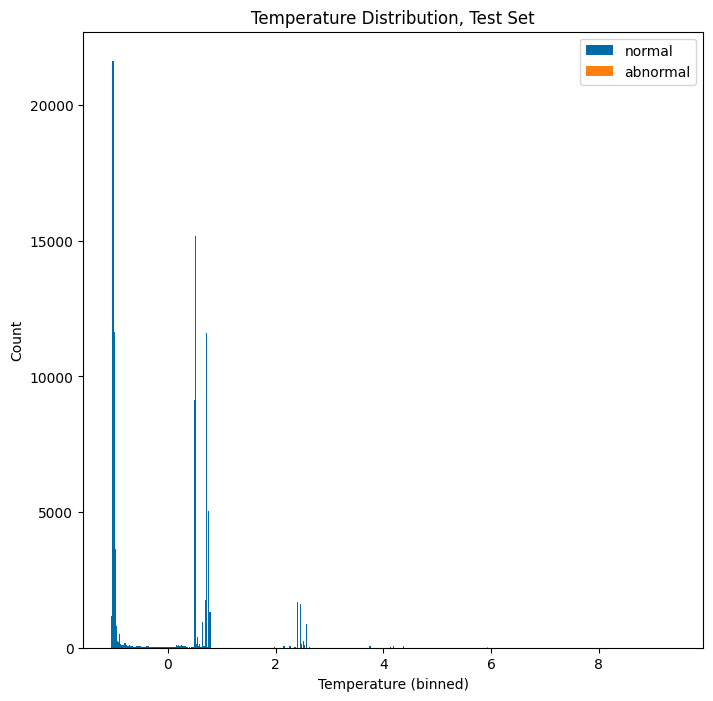

In [338]:
anomalies_value = data_with_losses_unscaled_test.loc[data_with_losses_unscaled_test['anomaly'], ['loss','Length']]
normals_value = data_with_losses_unscaled_test.loc[~data_with_losses_unscaled_test['anomaly'], ['loss','Length']]
plt.figure(figsize=(8,8))
plt.hist([normals_value['Length'], anomalies_value['Length']], bins=500, stacked=True, label=['normal', 'abnormal'])
plt.title("Temperature Distribution, Test Set")
plt.xlabel("Temperature (binned)")
plt.ylabel("Count")
plt.legend()

In [339]:
data_with_losses_unscaled_test

,No.,Time,Source,Destination,Protocol,Length,Info,Stable,Processing_time,loss,anomaly
0,1,0.000000,0.092042,-0.304479,26,2.623732,443 > 45841 Len=1232,0,-0.001926,0.003159,False
1,2,-0.005975,-0.398769,0.462563,20,2.623732,2655 > 443 [ACK] Seq=1 Ack=1 Win=3708 Len=0 ...,0,-1.227310,0.003159,False
2,3,-0.005898,-0.398769,0.251517,20,2.623732,44538 > 443 [ACK] Seq=1 Ack=1 Win=1736 Len=0...,0,-1.227310,0.003159,False
3,4,-0.005898,-0.398769,0.251517,20,2.623732,44540 > 443 [ACK] Seq=1 Ack=1 Win=1734 Len=0...,0,-1.227310,0.003159,False
4,5,-0.005889,-0.398769,0.251517,20,2.623732,44540 > 443 [ACK] Seq=1 Ack=2761 Win=1736 Le...,0,-1.227310,0.003159,False
...,...,...,...,...,...,...,...,...,...,...,...
94179,94180,49.925389,0.094942,-0.304479,24,0.753657,Ignored Unknown Record,0,1.223459,0.000409,False
94180,94181,49.925487,-0.382179,-0.304479,26,0.502824,443 > 60352 Len=1250,0,-0.001926,0.000291,False
94181,94182,49.925488,-0.382179,-0.304479,26,0.502824,443 > 60352 Len=1250,0,-0.001926,0.000291,False
94182,94183,49.925728,-0.398769,0.254802,20,-1.019561,33158 > 443 [ACK] Seq=30172 Ack=15145944 Win...,0,1.223459,0.000322,False


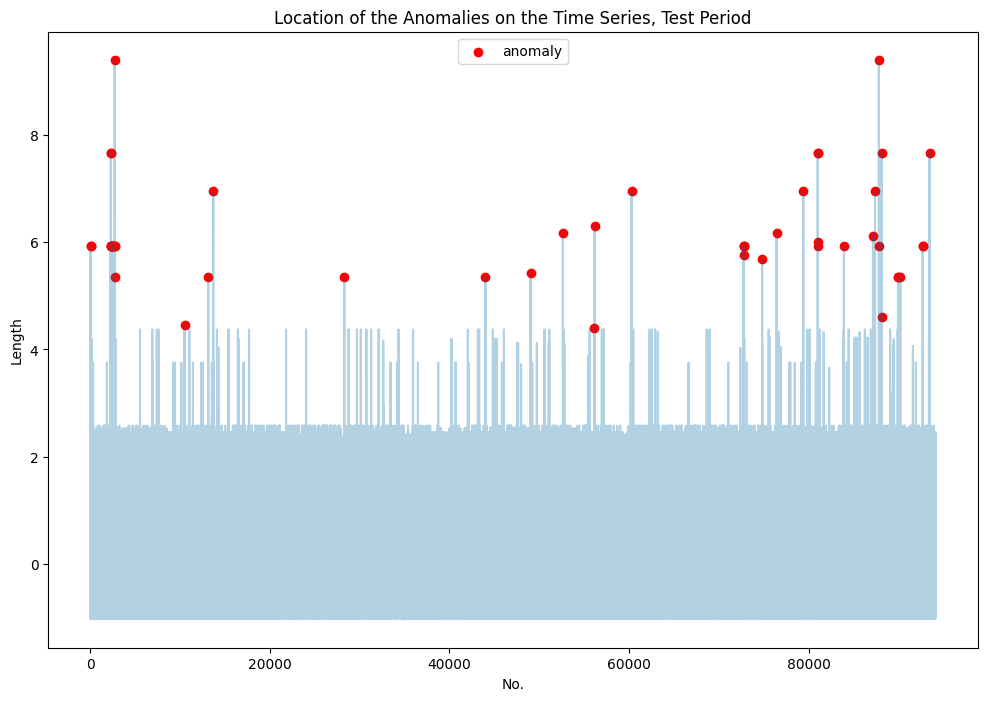

In [340]:
anomalies_ts = data_with_losses_unscaled_test.loc[data_with_losses_unscaled_test['anomaly'], ('No.', 'Length')]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data_with_losses_unscaled_test['No.'], data_with_losses_unscaled_test['Length'], alpha=0.3)
ax.scatter(anomalies_ts['No.'], anomalies_ts['Length'], color='red', label='anomaly')
plt.legend()
plt.xlabel("No.")
plt.ylabel("Length")
plt.title("Location of the Anomalies on the Time Series, Test Period");

In [341]:
anomalies_ts

,No.,Length
33,34,5.934236
52,53,5.934236
2259,2260,5.934236
2261,2262,5.934236
2278,2279,5.934236
2281,2282,7.672686
2291,2292,7.672686
2295,2296,5.934236
2407,2408,5.934236
2410,2411,5.934236
